In [1]:
%cd cache-prefetchers
! pip install sympy
from IPython import get_ipython

def git_pull():
    !git pull > /dev/null

get_ipython().events.register('pre_run_cell', git_pull)


/notebooks/cache-prefetchers


In [2]:
%load_ext autoreload
%autoreload 3


import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set
import abc
import torch
import dataclasses
import pandas as pd
import os
import copy
import time
import tqdm
from opt import opt_cache_simulation


from cache import Cache
from eviction import LRU, DOM, MQ, RandomEvictor
from prefetch import Next, Markov, EnsamblePrefetcher
from prob_model import FFM
from markov_generator import RandomMarkovGenerator
from fieldfm import train_ffm, FieldAwareFactorizationMachine, FieldAwareFactorizationMachineModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'torch'

In [2]:
@dataclasses.dataclass
class TestResult:

    cache_name: str
    miss_count: int
    trace_length: int
    unique_addresses: int
    execution_time: float


    def __repr__(self) -> str:
        return (
            f"Cache name: {self.cache_name}\n"
            f"Miss count: {self.miss_count}\n"
            f"Trace length: {self.trace_length}\n"
            f"Unique addresses: {self.unique_addresses}\n"
            f"Miss rate: {self.miss_count / self.trace_length}\n"
            f"Execution time: {self.execution_time}"
        )



def test_cache(cache: Cache, requests: List[int]) -> TestResult:
    """Returns cache miss count for given cache and requests."""
    cache = copy.deepcopy(cache)
    time_start = time.time()

    misses = 0
    for r in tqdm.tqdm(requests):
        if not cache.read(r):
            misses += 1

    time_end = time.time()

    return TestResult(
        cache_name=cache.name,
        miss_count=misses,
        trace_length=len(requests),
        unique_addresses=len(set(requests)),
        execution_time=time_end - time_start,
    )


def get_opt_for_sequence(sequence: list[int], cache_size=8) -> TestResult:
    total_length = 0
    unique_addresses = set()

    unique_addresses.update(sequence)

    misses = opt_cache_simulation(sequence, cache_size)

    return TestResult(
        cache_name="OPT",
        miss_count=misses,
        unique_addresses=len(set(unique_addresses)),
        trace_length=total_length,
        execution_time=None
    )

def test_markov_sequences(caches: List[Cache], sequences: List[List[int]], cache_size: int):
    file_name = f"markov_sequences_{cache_size}.csv"

    if os.path.exists(file_name):
        res = pd.read_csv(file_name, index_col=0)
    else:
        res = pd.DataFrame()

    for i, seq in enumerate(sequences):
        if not (len(res) > 0 and len(res[(res['cache'] == 'OPT') & (res['seq'] == i)]) > 0):
            opt_res = get_opt_for_sequence(seq, cache_size)
            new_row = pd.DataFrame([{
                'seq': i,
                'cache': 'OPT',
                'miss_count': opt_res.miss_count,
                'trace_length': opt_res.trace_length,
                'unique_addresses': opt_res.unique_addresses,
                'execution_time': opt_res.execution_time
            }])
            res = pd.concat([res, new_row])
            res.to_csv(file_name)

        for cache in caches:
            if len(res) > 0 and len(res[(res['cache'] == cache.name) & (res['seq'] == i)]) > 0:
                continue

            print("=======================================")
            print(f"Sequence {i}, cache: {cache.name}")
            print("=======================================")
            try:
                test_result = test_cache(cache, seq)
            except Exception as exc:
                print("ERROR", exc)
                continue

            new_row = pd.DataFrame([{
                'seq': i,
                'cache': cache.name,
                'miss_count': test_result.miss_count,
                'trace_length': test_result.trace_length,
                'unique_addresses': test_result.unique_addresses,
                'execution_time': test_result.execution_time
            }])
            res = pd.concat([res, new_row])
            res.to_csv(file_name)

    res['miss_rate'] = res['miss_count'] / res['trace_length']
    res = res.sort_values(by=['seq', 'miss_rate'])

    return res


In [47]:
SEQ_LEN = 50000
N = 10  # Address space size
SEQ_COUNT = 3  # Number of sequences to generate
CACHE_SIZE = 16
generator = RandomMarkovGenerator(N)
sequences = [
    generator.generate_sequence(SEQ_LEN)
    for _ in range(SEQ_COUNT)
]


In [48]:
print(generator.transition_matrix)

[[0.09829626 0.03500113 0.02446128 0.09607353 0.19375179 0.05405691
  0.14833168 0.15312208 0.01619671 0.18070863]
 [0.14091671 0.06569584 0.04420682 0.187211   0.04003529 0.19230812
  0.16754346 0.00300972 0.00729082 0.15178223]
 [0.10067302 0.02432985 0.12591897 0.0295735  0.20395507 0.15519258
  0.11003065 0.01295312 0.04956194 0.1878113 ]
 [0.07921192 0.08396095 0.1040151  0.17243183 0.14145707 0.12925679
  0.02889677 0.14674182 0.02368155 0.09034619]
 [0.1596687  0.03369768 0.01085821 0.19892187 0.00772564 0.1879061
  0.06558215 0.10969126 0.16496173 0.06098667]
 [0.11297928 0.02810801 0.02844043 0.08676153 0.1736365  0.01252974
  0.21125752 0.06723754 0.1630608  0.11598867]
 [0.11019935 0.00327729 0.19127701 0.11175201 0.20480128 0.15406843
  0.05749952 0.03880832 0.05679795 0.07151884]
 [0.11149179 0.11099472 0.22332367 0.08369271 0.04652892 0.02777586
  0.01574712 0.12392985 0.03034505 0.22617031]
 [0.09868014 0.02337528 0.14649152 0.06588238 0.05857646 0.1195899
  0.13270889 0

In [49]:
import random

from scipy import optimize
from fieldfm import FieldAwareFactorizationMachineModel
from torch import ge
n_samples = 100000
real_probs = []
target = []
N = 10

x = []
for i in range(n_samples):
    h = np.random.randint(0, N)
    a, b = random.sample(range(N), 2)
    r = random.random()

    if r < generator.transition_matrix[h][a]:
        y = 1
    else:
        y = 0

    x.append([h, a, b])
    target.append(y)
    real_probs.append(generator.transition_matrix[h][a])

Real transition matrix
[[0.09829626 0.03500113 0.02446128 0.09607353 0.19375179 0.05405691
  0.14833168 0.15312208 0.01619671 0.18070863]
 [0.14091671 0.06569584 0.04420682 0.187211   0.04003529 0.19230812
  0.16754346 0.00300972 0.00729082 0.15178223]
 [0.10067302 0.02432985 0.12591897 0.0295735  0.20395507 0.15519258
  0.11003065 0.01295312 0.04956194 0.1878113 ]
 [0.07921192 0.08396095 0.1040151  0.17243183 0.14145707 0.12925679
  0.02889677 0.14674182 0.02368155 0.09034619]
 [0.1596687  0.03369768 0.01085821 0.19892187 0.00772564 0.1879061
  0.06558215 0.10969126 0.16496173 0.06098667]
 [0.11297928 0.02810801 0.02844043 0.08676153 0.1736365  0.01252974
  0.21125752 0.06723754 0.1630608  0.11598867]
 [0.11019935 0.00327729 0.19127701 0.11175201 0.20480128 0.15406843
  0.05749952 0.03880832 0.05679795 0.07151884]
 [0.11149179 0.11099472 0.22332367 0.08369271 0.04652892 0.02777586
  0.01574712 0.12392985 0.03034505 0.22617031]
 [0.09868014 0.02337528 0.14649152 0.06588238 0.05857646 0

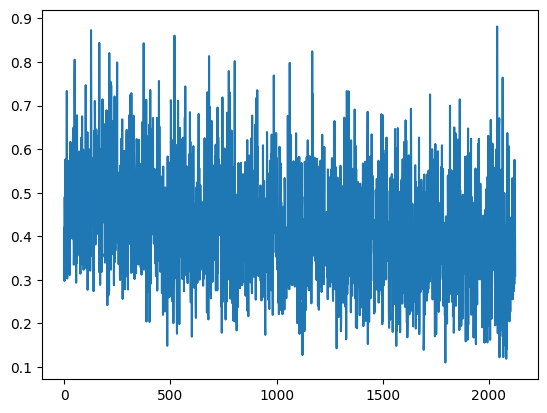

In [50]:
model = FieldAwareFactorizationMachineModel([N]*3, 8)
real_probs = torch.tensor(real_probs, dtype=torch.float32)
#target = real_probs
target = torch.tensor(target, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.long)

optimizer = torch.optim.Adagrad(model.parameters(), lr=5e-3, weight_decay=5e-4)
criterion = torch.nn.BCELoss()
batch_size = 32
losses = []
for i in range(n_samples//batch_size):
    batch_x = x[i*batch_size:(i+1)*batch_size]
    batch_y = target[i*batch_size:(i+1)*batch_size]


    output = model(batch_x)
    loss = criterion(output, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


learned_transition_matrix = np.zeros((N, N))
for a in range(N):
    for b in range(N):
        learned_transition_matrix[a][a] = model(torch.tensor([[a, a, b]]))[0].item()
        learned_transition_matrix[a][b] = model(torch.tensor([[a, b, b]]))[0].item()


print("Real transition matrix")
print(generator.transition_matrix)

print("Learned transition matrix")
print(learned_transition_matrix)

print(losses[-1])
plt.plot(losses[1000:])

In [232]:
generator = RandomMarkovGenerator(32)
requests = generator.generate_sequence(50000)
print(generator.transition_matrix)

[[0.03421354 0.03642507 0.02115866 ... 0.01022481 0.0371022  0.04029498]
 [0.02925908 0.06237806 0.01625547 ... 0.01174818 0.01805824 0.01307065]
 [0.01846881 0.0501551  0.01592541 ... 0.01752975 0.05048043 0.02578443]
 ...
 [0.03477859 0.0634959  0.04073831 ... 0.01948571 0.04454362 0.02462597]
 [0.0296042  0.03826438 0.00545807 ... 0.01743923 0.02255313 0.05179763]
 [0.03552741 0.01995579 0.01580646 ... 0.03945924 0.02066863 0.02805857]]


In [270]:


from distr_dom import test_on_sequence as test_on_sequence_dom
config = dict(
    cache_size=16, greedy=False, history_size=1, n_pages=32, hidden_size=128,
    n_deltas=2048, emb_size=8, delta_emb_size=32, lr=5e-2, train_interval=100,
    batch_size=32, train_samples=1000, train_next_delta=False, hash_mapping=True,
    model_class='ffm', wd=1e-4,
)
misses, misses_history, losses, evict_counts, model = test_on_sequence_dom(requests, **config)

print(misses)


Misses: 0, Loss p(a,b): 0, Loss delta: 0, Random loss: 0:   0%|          | 20/50000 [00:00<00:20, 2429.86it/s]


RuntimeError: only Tensors of floating point dtype can require gradients

In [216]:
print(model([1], [0], [1], [0], [0], [0]))

tensor([0.5220], grad_fn=<SigmoidBackward0>)


In [16]:
import random
from distr import test_on_sequence

misses, losses = test_on_sequence(sequences[0], CACHE_SIZE, N, greedy=False, history_size=2)

print(misses)
plt.plot(losses)


NameError: name 'sequences' is not defined

In [234]:
random_cache = Cache(
    name="RandomEvictor",
    eviction_strategy=RandomEvictor(),
    size=CACHE_SIZE
)
random_cache = copy.deepcopy(random_cache)
test_res = test_cache(random_cache, requests)
print(test_res)


AttributeError: type object 'datetime.time' has no attribute 'time'

In [24]:
caches = [
    Cache(
        name="RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=CACHE_SIZE
    ),
    Cache(
        name="LRU",
        eviction_strategy=LRU(),
        size=CACHE_SIZE
    ),
    Cache(
        name="MQ",
        eviction_strategy=MQ(),
        size=CACHE_SIZE
    ),
    Cache(
        name="MQ + MARKOV(3)",
        eviction_strategy=MQ(),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
    Cache(
        name="DOM(FFM(n=N, h=1, k=10))",
        eviction_strategy=DOM(FFM(n=N, h=1, k=10, my_ffm=False), train_interval=50),
        size=CACHE_SIZE
    ),
    Cache(
        name="RandomEvictor + NEXT",
        eviction_strategy=RandomEvictor(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="MQ + NEXT",
        eviction_strategy=MQ(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="DOM(FFM(n=N, h=14, k=10)) + NEXT",
        eviction_strategy=DOM(FFM(n=N, h=14, k=10), train_interval=50),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="RandomEvictor + MARKOV(3)",
        eviction_strategy=RandomEvictor(),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
    Cache(
        name="LRU + MARKOV(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
    Cache(
        name="DOM(FFM(n=N, h=14, k=10)) + MARKOV(3)",
        eviction_strategy=DOM(FFM(n=N, h=14, k=10)),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
][:4]


import itertools
H = [1]
K = [10]
TRAIN_INTERVAL = [50]
SAMPLES = [400]
EPOCHS = [2]
WD = [0.1]
LR = [0.001, 0.01]
WITH_NEUTRAL = [True, False]


grid = itertools.product(
    H, K, TRAIN_INTERVAL, SAMPLES, EPOCHS, WD, LR, WITH_NEUTRAL
)

for h, k, train_interval, samples, epochs, wd, lr, with_neutral in grid:
    name = (
        f"DOM(FFM("
        f"n=N "
        f"h={h} "
        f"k={k} "
        f"e_s={samples} "
        f"t_i={train_interval} "
        f"e={epochs} "
        f"lr={lr} "
        f"wd={wd} "
        f"neutral={with_neutral}"
        "))"
    )

    cache = Cache(
        name=name,
        eviction_strategy=DOM(
            FFM(
                n=N, h=h, k=k, epoch_samples=samples, lr=lr, wd=wd, epochs=epochs,
                with_neutral=with_neutral
            ),
            train_interval=train_interval
        ),
        size=CACHE_SIZE
    )
    caches.append(cache)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
test_markov_sequences(caches, sequences, CACHE_SIZE)

Sequence 1, cache: DOM(FFM(n=N h=1 k=10 e_s=400 t_i=50 e=2 lr=0.001 wd=0.1 neutral=False))


100%|██████████| 50000/50000 [05:13<00:00, 159.61it/s]


Sequence 1, cache: DOM(FFM(n=N h=1 k=10 e_s=400 t_i=50 e=2 lr=0.01 wd=0.1 neutral=True))


100%|██████████| 50000/50000 [05:13<00:00, 159.54it/s]


Sequence 1, cache: DOM(FFM(n=N h=1 k=10 e_s=400 t_i=50 e=2 lr=0.01 wd=0.1 neutral=False))


 18%|█▊        | 8970/50000 [00:59<04:30, 151.69it/s]


KeyboardInterrupt: 

# Tests on HUAWEI traces

In [51]:
from hwi_dataset import read_trace, get_test_set, get_reads, get_page_requests
from collections import defaultdict
test_set = get_test_set()

values = defaultdict(int)

times = []
all_length = 0
test_dir = '3'
all_unique = set()
all_unique_pages = 0
all_pages_length = 0

for v, volume in enumerate(test_set[test_dir]):
    print("volume", v)

    times_volume = []
    unique_volume = set()
    length_volume = 0
    unique_pages_volume = set()
    length_pages_volume = 0

    for p, path in enumerate(volume):
        print("path", path)
        trace = read_trace(test_set[test_dir][v][p])
        reads = trace[trace['tp'] == 'READ']
        print(reads['volumeId'].unique())

        times_volume.extend(list(reads['last time nano'].values))
        unique_volume.update(reads['objLba'].unique())

        length_volume += len(reads)

        print('length path', len(reads))

        pages = get_page_requests(get_reads(read_trace(path)), page_size=16*1024)
        unique_pages_path = len(set(pages))
        unique_pages_volume.update(set(pages))
        length_pages_volume += len(pages)
        print('unique pages within path', unique_pages_path)


        print("=======================================\n")

    print('is times sorted within volume?' , all(times_volume[i] <= times_volume[i+1] for i in range(len(times_volume)-1)))
    print('unique addresses within volume', len(unique_volume))
    print('length volume', length_volume)
    print('unique pages within volume', len(unique_pages_volume))

    times.extend(times_volume)
    all_unique.update(unique_volume)
    all_length += length_volume
    all_unique_pages += len(unique_pages_volume)
    all_pages_length += length_pages_volume
    print("##################\n")

print('is times sorted?' , all(times[i] <= times[i+1] for i in range(len(times)-1)))
print('unique addresses', len(all_unique))
print("all length", all_length)
print("all unique pages", all_unique_pages)
print("all pages length", all_pages_length)
trace = read_trace(test_set[test_dir][0][0])
trace


volume 0
path ../trace/Trace/3/trace_150_0/cache_trace_150_0_6


AttributeError: 'DataFrame' object has no attribute 'map'

In [10]:
page_size = 16*1024
test_dir_name = '2'
test_set = get_test_set()
requests = []

for volume_paths in sorted(test_set[test_dir_name])[:1]:
    print(f"Volume {volume_paths[0].split('/')[-2]}")

    for path in tqdm.tqdm(volume_paths):
        requests.extend(get_page_requests(get_reads(read_trace(path)), page_size=page_size))

print("unique pages", len(set(requests)))
print("length", len(requests))

Volume cache_trace_3


100%|██████████| 11/11 [00:00<00:00, 24.68it/s]

unique pages 206
length 58868


In [120]:


from distr_dom import test_on_sequence as test_on_sequence_dom
config = dict(
    cache_size=16, greedy=False, history_size=16, n_pages=210, hidden_size=128,
    n_deltas=2048, emb_size=10, delta_emb_size=32, lr=1e-2, train_interval=100,
    batch_size=256, train_samples=200, train_next_delta=False, hash_mapping=False,
    model_class='ffm', wd=0.001,
)
misses, misses_history, losses, evict_counts, model = test_on_sequence_dom(requests, **config)

print(misses)

Misses: 3014, Loss p(a,b): 0.6779545545578003, Loss delta: 0.0, Random loss: 0.7419514656066895: 100%|██████████| 58868/58868 [45:20<00:00, 21.64it/s]   

3014


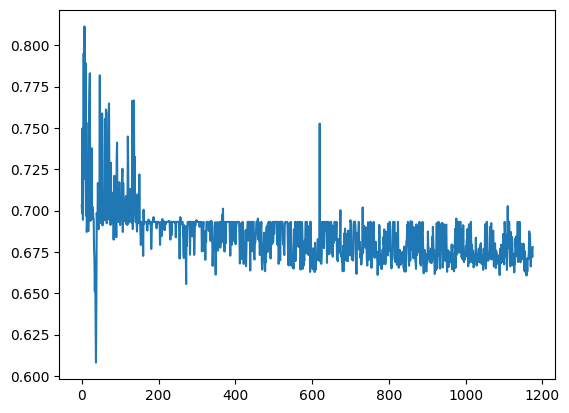

In [86]:
plt.plot(losses)

In [67]:

misses, misses_history, losses, evict_counts, model = test_on_sequence_dom(requests, **config, from_model=model)

print(misses)

Misses: 0, Loss p(a,b): 0, Loss delta: 0, Random loss: 0:   0%|          | 0/58868 [00:00<?, ?it/s]/Users/robertlaskowski/Desktop/studia/projects/prefetching/IDEAS_prefetchers/distr_dom.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_target = torch.tensor(batch.pop("prob")).float()
Misses: 494, Loss p(a,b): 0.6452830992639065, Loss delta: 0.0, Random loss: 1.0031001567840576:  17%|█▋        | 10100/58868 [01:23<06:40, 121.63it/s]


KeyboardInterrupt: 

In [235]:
def test_random_evictor(requests: List[int], cache_size: int) -> TestResult:
    cache = set()
    misses = 0
    for r in tqdm.tqdm(requests):
        if len(cache) < cache_size:
            cache.add(r)
        elif r not in cache:
            evict_el = random.choice(list(cache))
            cache.remove(evict_el)
            misses += 1

            cache.add(r)
    print(f"Misses: {misses}")

    cache = Cache(
        name="RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=cache_size
    )
    misses2 = 0
    for r in tqdm.tqdm(requests):
        misses2 += int(not cache.read(r))
    print(f"Misses2: {misses2}")
    cache = set()
    misses3 = 0
    for r in tqdm.tqdm(requests):
        if len(cache) < cache_size:
            cache.add(r)
        elif r not in cache:
            evict_el = list(cache)[0]
            cache.remove(evict_el)
            misses3 += 1

    print(f"Misses3: {misses3}")


    return misses

test_random_evictor(requests, 16)

100%|██████████| 50000/50000 [00:00<00:00, 1176727.51it/s]


Misses: 24708


100%|██████████| 50000/50000 [00:00<00:00, 65985.61it/s]


Misses2: 24885


100%|██████████| 50000/50000 [00:00<00:00, 2469998.23it/s]

Misses3: 12944


24708

In [18]:

def get_opt_for_test_dir(test_set_dir, page_size=16*1024, cache_size=8) -> TestResult:
    requests = []
    for volume_paths in sorted(test_set[test_set_dir]):
        for path in volume_paths:
            requests.extend(get_page_requests(get_reads(read_trace(path)), page_size=page_size))


    misses = opt_cache_simulation(requests, cache_size)

    return TestResult(
        cache_name="OPT",
        miss_count=misses,
        unique_addresses=len(set(requests)),
        trace_length=len(requests),
        execution_time=None
    )


In [125]:
import pandas as pd
import os

test_dirs = [
    #'1',
    #'2',
    '3',
    #'11',
    #'scenario_test_trace_simple/VDI_virus_scan'
]

def test_case(test_dir_name: str, cache: Cache, page_size=16*1024) -> TestResult:
    start_time = time.time()

    cache_factory = lambda: copy.deepcopy(cache)
    cache = cache_factory()
    requests = []
    total_misses = 0
    for i, volume_paths in enumerate(sorted(test_set[test_dir_name])):
        if test_dir_name == '3':
            if i != 0:
                continue

        for path in volume_paths:
            requests.extend(get_page_requests(get_reads(read_trace(path)), page_size=page_size))

    for r in tqdm.tqdm(requests):
        hit = cache.read(r)
        total_misses += int(not hit)


    return TestResult(
        cache_name=cache.name,
        miss_count=total_misses,
        unique_addresses=len(set(requests)),
        trace_length=len(requests),
        execution_time=round(time.time() - start_time, 3)
    )

def test(caches: List[Cache], test_dirs: List[str], cache_size, page_size=16*1024) -> pd.DataFrame:
    file_name = f'results_{page_size}_{cache_size}.csv'
    if os.path.exists(file_name):
        res = pd.read_csv(file_name, dtype={'test_dir': str}, index_col=0)
    else:
        res = pd.DataFrame()

    for test_dir in test_dirs:
        for cache in caches:

            if len(res) > 0 and len(res[(res['cache'] == cache.name) & (res['test_dir'] == test_dir)]) > 0:
                continue


            print("=======================================")
            print(f"Test dir: {test_dir}, cache: {cache.name}")
            print("=======================================")
            try:
                test_result = test_case(test_dir, cache, page_size=page_size)
            except Exception as exc:
                print("ERROR", exc)
                continue

            new_row = pd.DataFrame([{
                'test_dir': test_dir,
                'cache': cache.name,
                'miss_count': test_result.miss_count,
                'trace_length': test_result.trace_length,
                'unique_addresses': test_result.unique_addresses,
                'page_size': page_size,
                'execution_time': test_result.execution_time
            }])
            res = pd.concat([res, new_row])
            res.to_csv(file_name)

        if len(res) > 0 and len(res[(res['cache'] == 'OPT') & (res['test_dir'] == test_dir)]) > 0:
            continue

        opt_res = get_opt_for_test_dir(test_dir, page_size=page_size, cache_size=cache_size)
        new_row = pd.DataFrame([{
            'test_dir': test_dir,
            'cache': 'OPT',
            'miss_count': opt_res.miss_count,
            'trace_length': opt_res.trace_length,
            'unique_addresses': opt_res.unique_addresses,
            'page_size': page_size,
            'execution_time': opt_res.execution_time
        }])
        res = pd.concat([res, new_row])
        res.to_csv(file_name)

    res['miss_rate'] = res['miss_count'] / res['trace_length']
    res = res.sort_values(by=['test_dir', 'miss_rate'])

    return res


In [126]:

caches_size_16 = [
    Cache(
        "RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=16
    ),
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=16
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=16
    ),
    Cache(
        "DOM(FFM(n=10000,k=10,h=14))",
        eviction_strategy=DOM(prob_model=FFM(n=10000, k=10, h=14)),
        size=16
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + Markov(3)",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "DOM(FFM(n=10000,k=10,h=14)) + NEXT",
        eviction_strategy=DOM(prob_model=FFM(n=1000, k=10, h=14)),
        prefetch_strategy=Next(),
        size=16
    ),
][:3]


In [127]:
test(caches_size_16, test_dirs, 16, page_size=16*1024)


Test dir: 3, cache: RandomEvictor


100%|██████████| 47855/47855 [00:01<00:00, 44616.31it/s]


Test dir: 3, cache: LRU


100%|██████████| 47855/47855 [00:01<00:00, 43226.17it/s]


Test dir: 3, cache: MQ


100%|██████████| 47855/47855 [00:02<00:00, 22562.21it/s]
/var/folders/wv/wmn__gfj1j188w6fb4gdzvn80000gn/T/ipykernel_53921/895955442.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, new_row])


,test_dir,cache,miss_count,trace_length,unique_addresses,page_size,execution_time,miss_rate
0,3,OPT,13742,200375,6989,16384,NaN,0.068581
0,3,LRU,4044,47855,2577,16384,1.956,0.084505
0,3,MQ,4062,47855,2577,16384,2.921,0.084881
0,3,RandomEvictor,4740,47855,2577,16384,1.962,0.099049


In [533]:

caches_size_64 = [
    Cache(
        "RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=64
    ),
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=64
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=64
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=64
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=64
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=64
    ),
    Cache(
        "MQ + Markov(3)",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Markov(3),
        size=64
    ),
]
test(caches_size_64, test_dirs, 64, page_size=16*1024)


,test_dir,cache,miss_count,trace_length,unique_addresses,page_size,execution_time,miss_rate
0,1,OPT,961,61932,14281,16384,None,0.015517
0,1,MQ,48394,61932,14281,16384,9.215,0.781405
0,1,LRU,48415,61932,14281,16384,3.677,0.781744
0,1,RandomEvictor,48952,61932,14281,16384,3.942,0.790415
0,1,MQ + Markov(3),49298,61932,14281,16384,8.863,0.796002
0,1,MQ + NEXT,49328,61932,14281,16384,9.126,0.796486
0,1,LRU + NEXT,49363,61932,14281,16384,4.099,0.797052
0,1,LRU + Markov(3),51446,61932,14281,16384,4.332,0.830685
0,1,"DOM(FFM(n=10000,k=10,h=6))",52467,61932,14281,16384,2194.868,0.847171
0,1,"DOM(FFM(n=10000,k=10,h=6)) + NEXT",57120,61932,14281,16384,4587.174,0.922302


## Tests on smaller page sizes

In [ ]:

caches_size_16_smaller_pages = [
    Cache(
        "RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=16
    ),
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=16
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=16
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + Markov(3)",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Markov(3),
        size=16
    ),
]


### Page size - 512 Bytes

In [532]:
test(caches_size_64, test_dirs, 16, page_size=512)


,test_dir,cache,miss_count,trace_length,unique_addresses,page_size,execution_time,miss_rate
0,1,OPT,961,61932,41935,512,None,0.015517
0,1,MQ + Markov(3),51928,61932,41935,512,14.455,0.838468
0,1,MQ + NEXT,51956,61932,41935,512,14.73,0.838920
0,1,LRU + NEXT,51961,61932,41935,512,6.371,0.839001
0,1,LRU + Markov(3),53040,61932,41935,512,7.199,0.856423
0,1,LRU,53757,61932,41935,512,9.004,0.868000
0,1,MQ,53765,61932,41935,512,10.213,0.868130
0,1,RandomEvictor,54045,61932,41935,512,6.805,0.872651
0,11,OPT,209,57867,29936,512,None,0.003612
0,11,MQ + Markov(3),45893,57867,29936,512,15.915,0.793077
